In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("crop_yield_SL_IN.csv")

print("Shape:", df.shape)
df.head()

Shape: (4232, 7)


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,India,Cassava,1990,205381,1083,75000.0,25.58
1,India,Cassava,1990,205381,1083,75000.0,26.88
2,India,Cassava,1990,205381,1083,75000.0,25.79
3,India,Cassava,1990,205381,1083,75000.0,24.10
4,India,Cassava,1990,205381,1083,75000.0,25.25


In [16]:
df.isnull().sum()


Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [17]:
df = df.drop(columns=["Area", "Year"])


In [18]:
X = df.drop(columns=["hg/ha_yield"])
y = np.log1p(df["hg/ha_yield"])                             


In [19]:
# categorical columns
categorical_features = ["Item"]

# numerical columns
numerical_features = [
    "average_rain_fall_mm_per_year",
    "pesticides_tonnes",
    "avg_temp"
]

print("Categorical:", categorical_features)
print("Numerical:", numerical_features)


Categorical: ['Item']
Numerical: ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (3385, 4)
Test shape: (847, 4)


In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        # scale numerical features
        ("num", StandardScaler(), numerical_features),

        # one-hot encode categorical features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)



In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}


In [24]:
results = {}

for name, model in models.items():
    print("\n==============================")
    print(f"Training Model: {name}")
    print("==============================")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")

    # Save results
    results[name] = {
        "model": pipeline,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }



Training Model: Linear Regression
MAE  : 0.10
RMSE : 0.15
R²   : 0.9852

Training Model: Decision Tree
MAE  : 0.01
RMSE : 0.04
R²   : 0.9988

Training Model: Random Forest
MAE  : 0.01
RMSE : 0.04
R²   : 0.9990

Training Model: XGBoost
MAE  : 0.02
RMSE : 0.04
R²   : 0.9990


In [25]:
results_df = (
    pd.DataFrame(results)
    .T.drop(columns=["model"])
    .sort_values(by="RMSE")
)

results_df


,MAE,RMSE,R2
Random Forest,0.005617,0.037165,0.999035
XGBoost,0.020613,0.03743,0.999021
Decision Tree,0.005721,0.041177,0.998815
Linear Regression,0.096785,0.145545,0.9852


In [27]:
best_model_name = results_df.index[0]
best_model = results[best_model_name]["model"]

print("✅ Best Model:", best_model_name)


✅ Best Model: Random Forest


In [28]:
import numpy as np

# Convert back to real yield values
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)


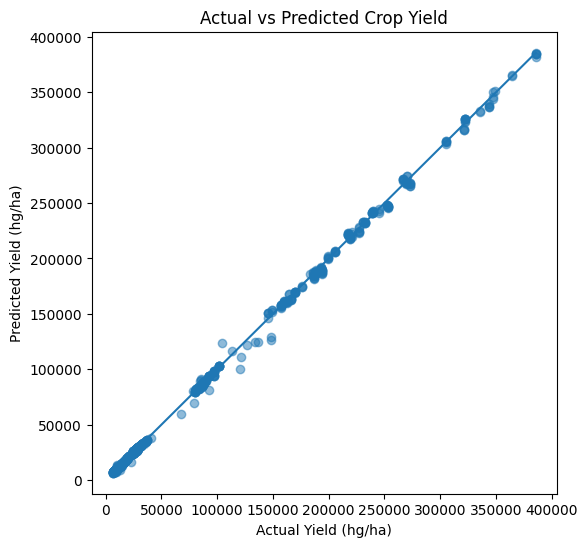

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred_real, alpha=0.5)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()]
)
plt.xlabel("Actual Yield (hg/ha)")
plt.ylabel("Predicted Yield (hg/ha)")
plt.title("Actual vs Predicted Crop Yield")
plt.show()


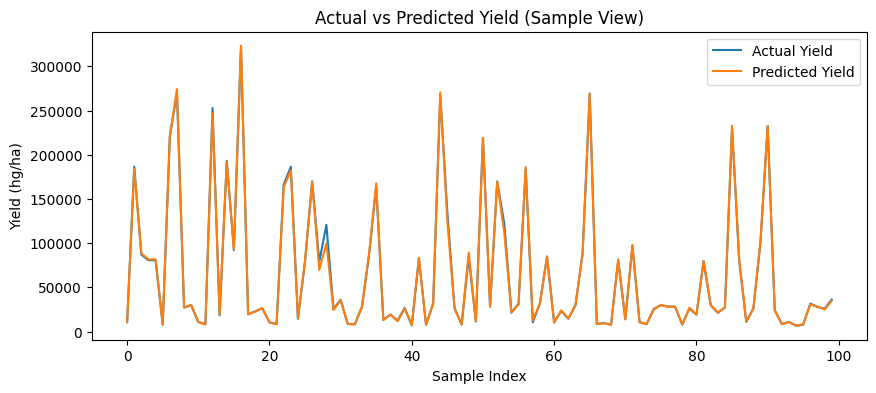

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_real.values[:100], label="Actual Yield")
plt.plot(y_pred_real[:100], label="Predicted Yield")
plt.xlabel("Sample Index")
plt.ylabel("Yield (hg/ha)")
plt.title("Actual vs Predicted Yield (Sample View)")
plt.legend()
plt.show()


In [32]:
import pandas as pd
import numpy as np

sample_input = {
    "Item": "Rice",  # change to a crop name that exists in your dataset
    "average_rain_fall_mm_per_year": 1800,
    "pesticides_tonnes": 2000,
    "avg_temp": 27.5
}

sample_df = pd.DataFrame([sample_input])
sample_df


,Item,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Rice,1800,2000,27.5


In [33]:
# Predict in LOG scale
pred_log = best_model.predict(sample_df)[0]

# Convert back to real yield
pred_yield = np.expm1(pred_log)

print("Predicted Yield (hg/ha):", pred_yield)


Predicted Yield (hg/ha): 29891.542481966964


In [34]:
best_model = results["XGBoost"]["model"]


In [35]:
import joblib

joblib.dump(best_model, "yield_prediction_model.joblib")
print("✅ Saved model as yield_prediction_model.joblib")


✅ Saved model as yield_prediction_model.joblib


In [36]:
feature_names = X.columns.tolist()
joblib.dump(feature_names, "yield_feature_names.joblib")
print("✅ Saved feature names as yield_feature_names.joblib")


✅ Saved feature names as yield_feature_names.joblib
